In [11]:
import numpy as np

from scoring import NoteList, extract_midi_notes, edit_distance


def get_notes(file_path) -> NoteList:
    if file_path.endswith(".midi"):
        return extract_midi_notes(file_path)
    with open(file_path, "rb") as f:
        (note_list := NoteList()).ParseFromString(f.read())
    return note_list


actual = get_notes("../scores/spider dance.scoredata")
played = get_notes("../audio/spider dance played.midi")

actual_notes = np.fromiter(actual.notes, dtype=object)
played_notes = np.fromiter(played.notes, dtype=object)
a_pitches = np.fromiter((n.pitch for n in actual_notes), dtype=np.int32)
p_pitches = np.fromiter((n.pitch for n in played_notes), dtype=np.int32)

edits, aligned = edit_distance(a_pitches, p_pitches, actual_notes, played_notes)

left_tuple, right_tuple = zip(*aligned)
a_aligned, p_aligned = actual_notes[list(left_tuple)], played_notes[list(right_tuple)]

2025-09-28 10:27:48.407 | INFO     | __main__:<module>:22 - 	[edit_distance] took 773.806 ms


In [12]:
from scoring import analyze_tempo

a_times = np.fromiter((a.start_time for a in a_aligned), dtype=np.float32)
p_times = np.fromiter((p.start_time for p in p_aligned), dtype=np.float32)
a_pages = np.fromiter((a.page for a in a_aligned), dtype=np.int32)
sections, unstable = analyze_tempo(actual_notes, played_notes, aligned)

In [13]:
y = a_times - p_times
x = np.arange(len(y))
unique_pages, first_idx = np.unique(a_pages, return_index=True)

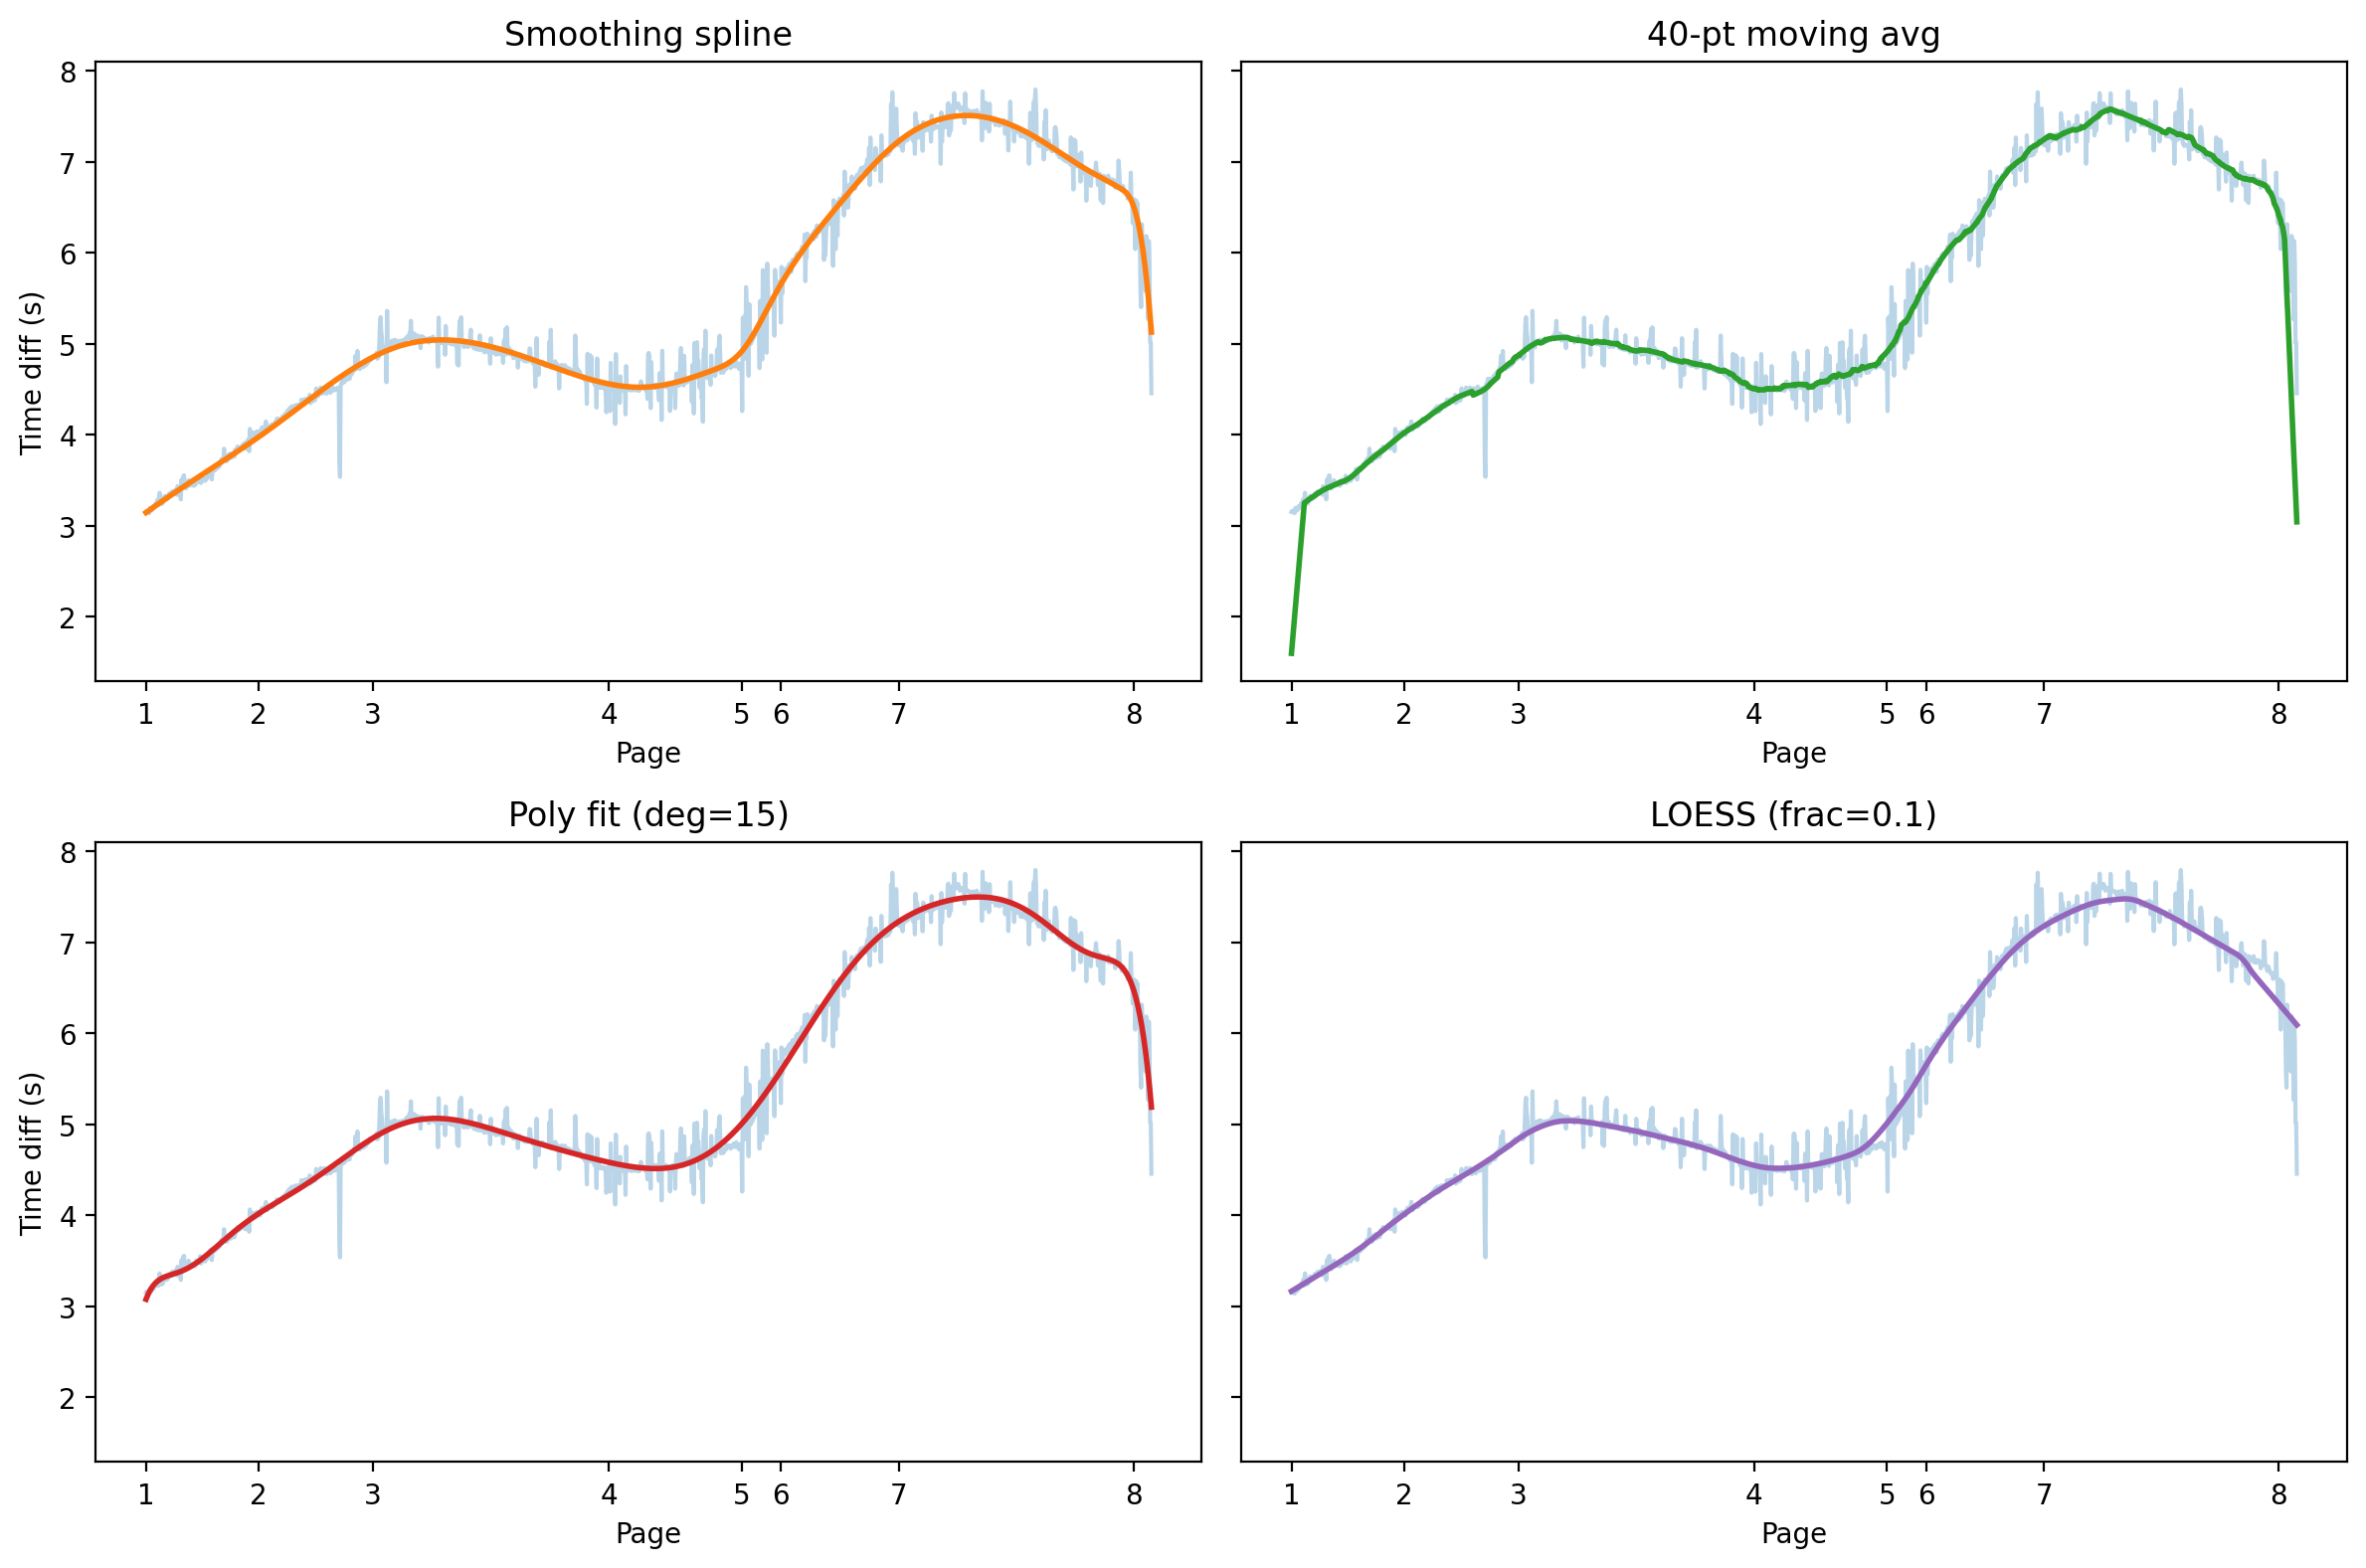

In [14]:
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1) smoothing spline
spl = UnivariateSpline(x, y, s=25)
y_smooth = spl(x)

# 2) moving average
window = 40
y_ma = np.convolve(y, np.ones(window) / window, mode="same")

# 3) polynomial fit (degree 3 here)
deg = 15
coeffs = np.polyfit(x, y, deg)
y_poly = np.poly1d(coeffs)(x)

# 4) LOWESS
lowess = sm.nonparametric.lowess
frac = 0.1
z = lowess(y, x, frac=frac)
x_lo, y_lo = z[:, 0], z[:, 1]

# create a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)

# Top-left: smoothing spline
ax = axes[0, 0]
ax.plot(x, y, alpha=0.3, color="C0")
ax.plot(x, y_smooth, lw=2, color="C1")
ax.set_xticks(first_idx)
ax.set_xticklabels(unique_pages + 1)
ax.set_title("Smoothing spline")
ax.set_xlabel("Page")
ax.set_ylabel("Time diff (s)")

# Top-right: moving average
ax = axes[0, 1]
ax.plot(x, y, alpha=0.3, color="C0")
ax.plot(x, y_ma, lw=2, color="C2")
ax.set_xticks(first_idx)
ax.set_xticklabels(unique_pages + 1)
ax.set_title(f"{window}-pt moving avg")
ax.set_xlabel("Page")

# Bottom-left: polynomial fit
ax = axes[1, 0]
ax.plot(x, y, alpha=0.3, color="C0")
ax.plot(x, y_poly, lw=2, color="C3")
ax.set_xticks(first_idx)
ax.set_xticklabels(unique_pages + 1)
ax.set_title(f"Poly fit (deg={deg})")
ax.set_xlabel("Page")
ax.set_ylabel("Time diff (s)")

# Bottom-right: LOESS
ax = axes[1, 1]
ax.plot(x, y, alpha=0.3, color="C0")
ax.plot(x_lo, y_lo, lw=2, color="C4")
ax.set_xticks(first_idx)
ax.set_xticklabels(unique_pages + 1)
ax.set_title(f"LOESS (frac={frac})")
ax.set_xlabel("Page")

plt.tight_layout()
plt.show()

In [15]:
start_to_aligned = {a: i for i, a in enumerate(left_tuple)}

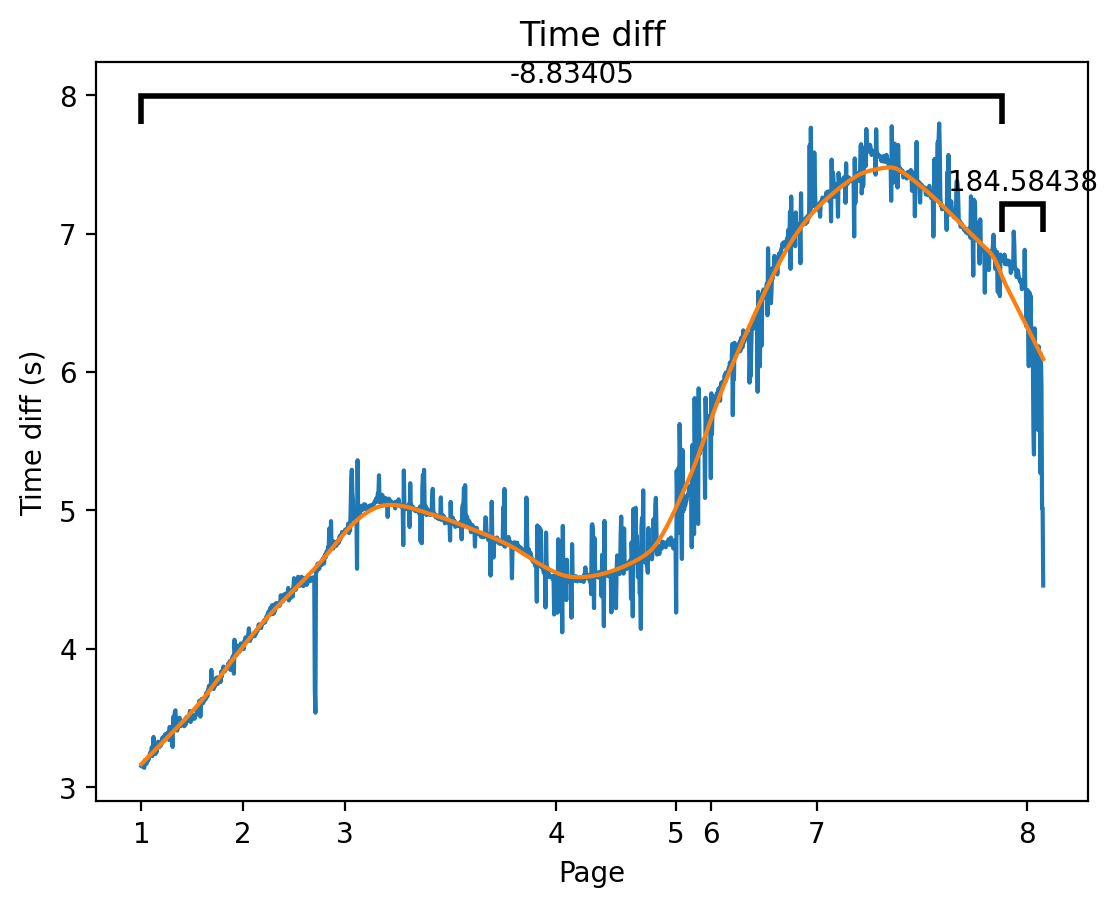

In [16]:
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np


def add_bracket(ax, x0, x1, y, height=0.2, text=None):
    """
    Draws a horizontal bracket above the plot between x0 and x1 at y.
    height: how tall the bracket arches up
    text: optional label centered above bracket
    """
    verts = [
        (x0, y),  # left
        (x0, y + height),  # up
        (x1, y + height),  # across
        (x1, y),  # down
    ]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, lw=2, color="black", fill=False)
    ax.add_patch(patch)

    if text:
        ax.text((x0 + x1) / 2, y + height + 0.05, text, ha="center", va="bottom")


for section in sections:
    add_bracket(
        plt.gca(),
        s := start_to_aligned[section.start_index],
        e := start_to_aligned[section.end_index],
        y[s:e].max(),
        text=f"{section.tempo:.5f}",
    )

plt.title("Time diff")
plt.xlabel("Page")
plt.ylabel("Time diff (s)")
plt.xticks(first_idx, unique_pages + 1)
plt.plot(x, y)
plt.plot(x_lo, y_lo)
plt.show()

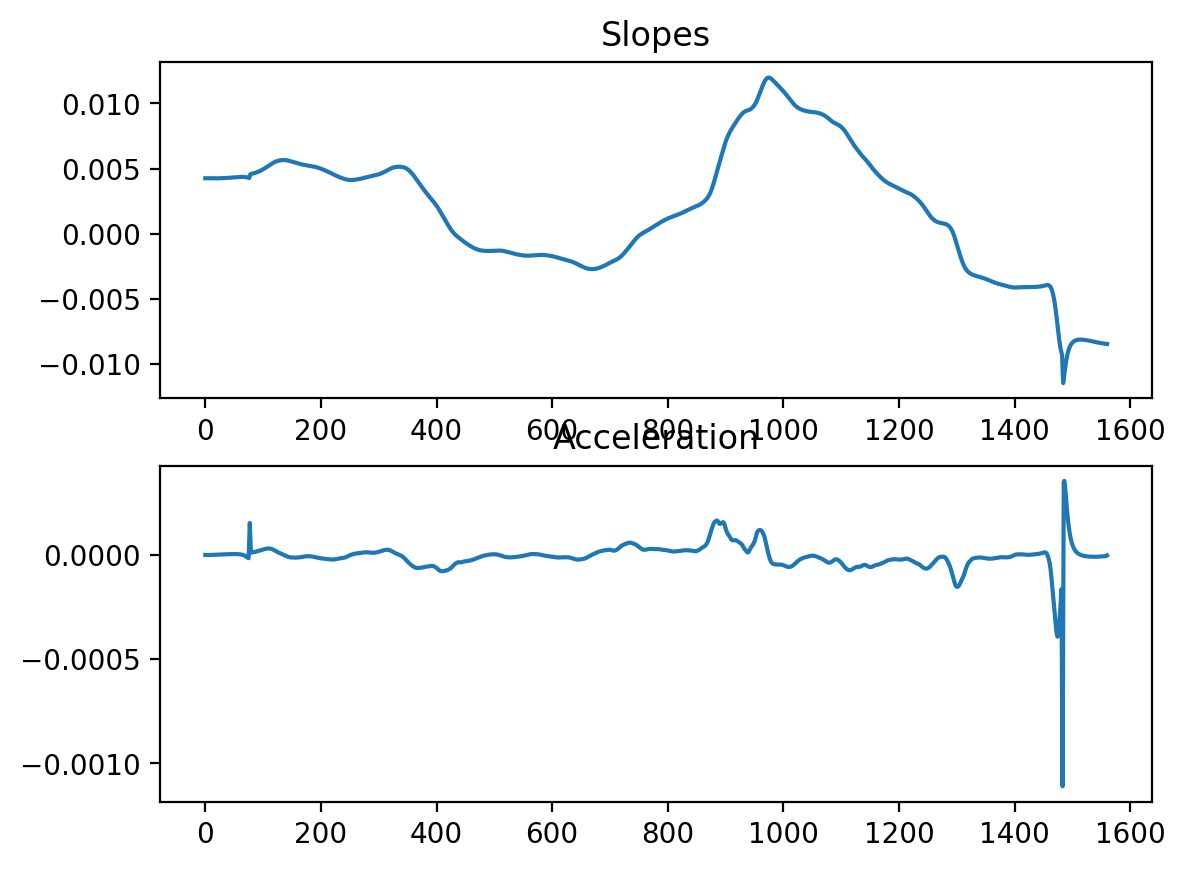

In [17]:
slopes = np.gradient(y_lo)
accel = np.gradient(slopes)
ax = plt.subplot(2, 1, 1)
ax.plot(x_lo, slopes)
ax.set_title("Slopes")
ax = plt.subplot(2, 1, 2)
ax.plot(x_lo, accel)
ax.set_title("Acceleration")
plt.show()

In [18]:
ur = np.std(slopes)
round(ur * 1e5)

486

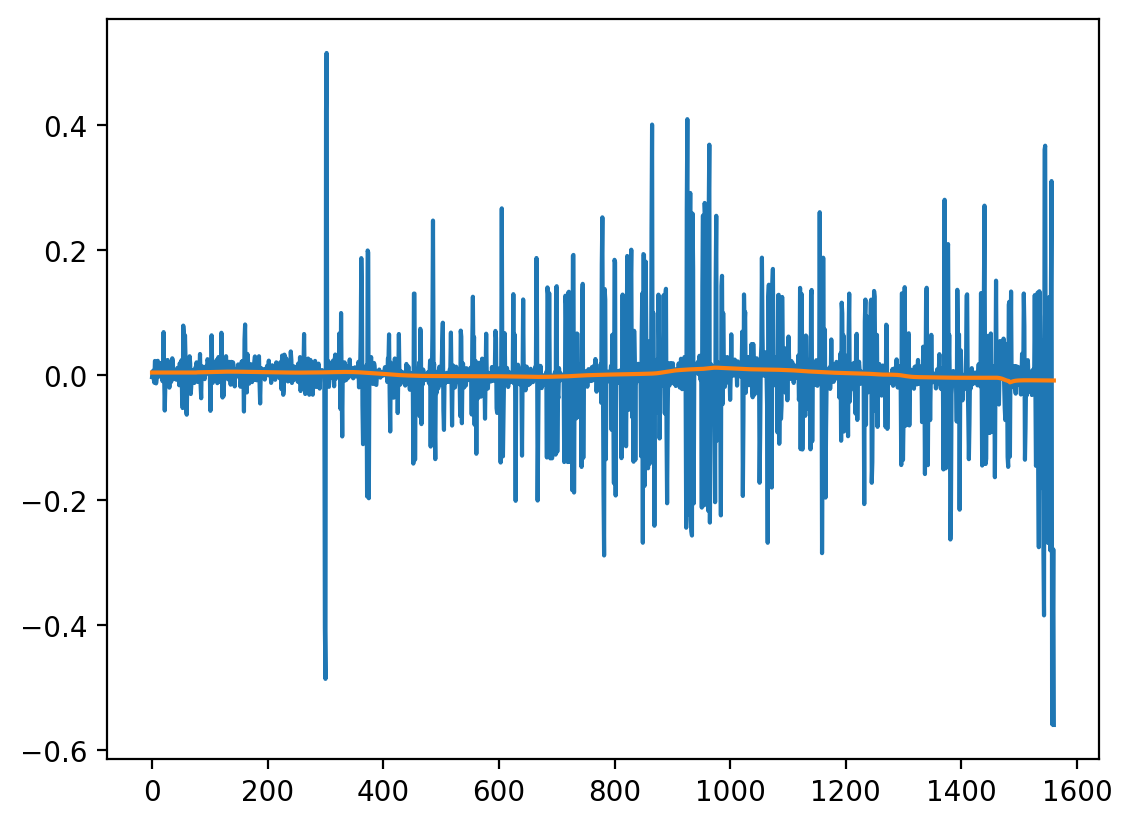

In [19]:
diff_changes = np.gradient(y)
plt.plot(x, diff_changes)
plt.plot(x_lo, slopes)
plt.show()

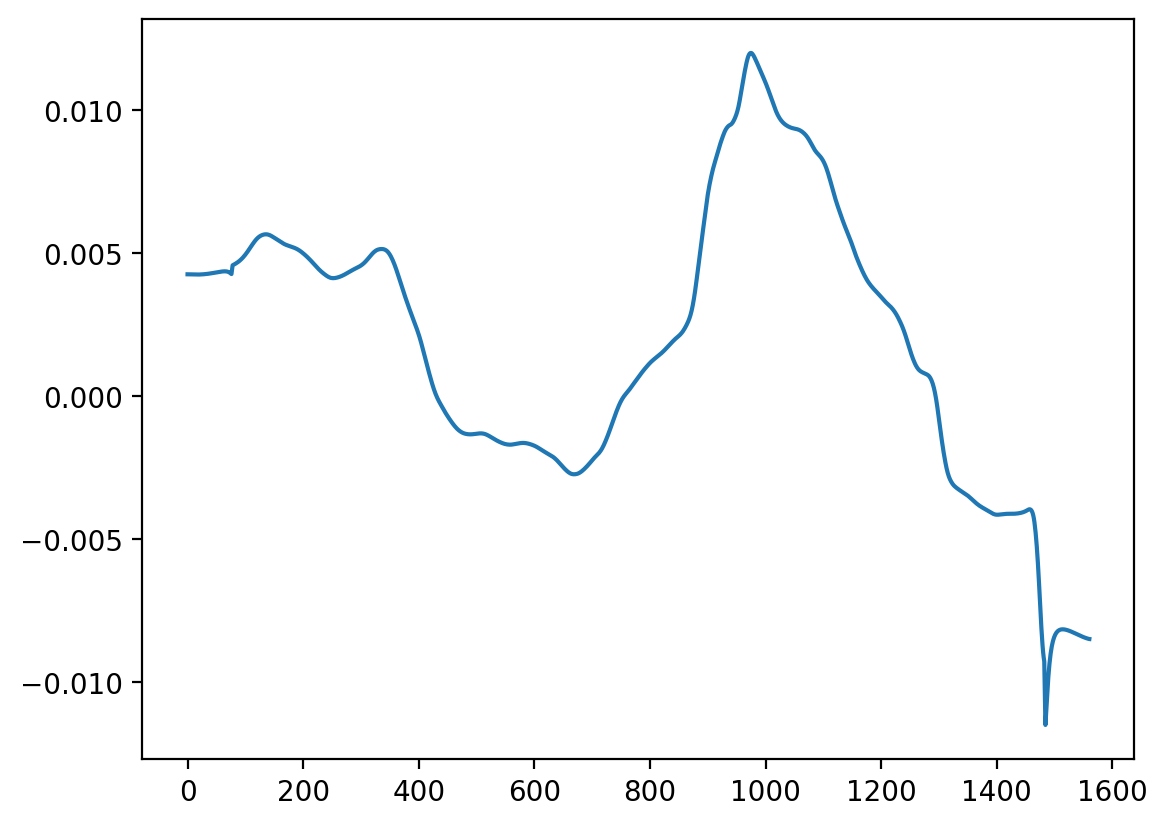

In [20]:
diff_changes = np.gradient(y)
plt.plot(x_lo, slopes)
plt.show()